#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
import warnings

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")

#### Data

In [2]:
cluster_monthly = pd.read_csv("cluster_monthly.csv")

In [3]:
cluster_monthly

,Cluster,date,total_amount
0,0,2010-01-31,"1,125,217.0400"
1,0,2010-02-28,"1,072,219.5800"
2,0,2010-03-31,"1,174,035.9600"
3,0,2010-04-30,"1,129,380.2700"
4,0,2010-05-31,"1,171,273.1400"
...,...,...,...
467,3,2019-06-30,"925,712.6900"
468,3,2019-07-31,"956,485.1600"
469,3,2019-08-31,"951,978.1400"
470,3,2019-09-30,"934,472.8500"


In [4]:
cluster_monthly['Cluster'].value_counts()

Cluster
0    118
1    118
2    118
3    118
Name: count, dtype: int64

#### Holt Winters

36-month window → 1-step ahead

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

def to_month_end(s):
    return pd.to_datetime(s).dt.to_period('M').dt.to_timestamp('M')

def prepare_cluster_series(cluster_monthly, cid, value_col="total_amount"):
    d = cluster_monthly.loc[cluster_monthly["Cluster"] == cid, ["date", value_col]].copy()
    d["date"] = to_month_end(d["date"])
    d[value_col] = (
        d[value_col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(float)
    )
    d = d.sort_values("date")
    y = d.set_index("date")[value_col].asfreq("M")  # 'M' or 'ME' both ok if consistent
    return y

def mape(y, yhat, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100.0

def fit_best_hw(train, s=12, allow_multiplicative=True):
    """Small grid-search over HW configs, pick lowest AIC on the train window."""
    positive = (train.min() > 0)
    seasonal_candidates = ["add"]
    if allow_multiplicative and positive:
        seasonal_candidates.append("mul")

    grid = []
    for trend in [None, "add"]:
        for seasonal in seasonal_candidates:
            for damped in [False, True]:
                grid.append(dict(trend=trend, seasonal=seasonal, damped_trend=damped))

    best = None
    best_aic = np.inf
    best_cfg = None

    for cfg in grid:
        try:
            model = ExponentialSmoothing(
                train,
                trend=cfg["trend"],
                damped_trend=cfg["damped_trend"],
                seasonal=cfg["seasonal"],
                seasonal_periods=s,
                initialization_method="estimated",
            )
            res = model.fit(optimized=True, use_brute=False)
            aic = getattr(res, "aic", np.inf)
            if aic < best_aic:
                best_aic, best, best_cfg = aic, res, cfg
        except Exception:
            continue

    return best, best_cfg

In [6]:
def rolling_forecast_holt_winters(
    ts,
    train_len=36,
    horizon=1,
    step=1,
    s=12,
    allow_multiplicative=True
):
    """
    Rolling 1-step (or h-step) ahead forecasts using Holt-Winters.
    Returns a DataFrame with columns: ['timestamp', 'Actual', 'Pred'].
    """
    ts = ts.asfreq('M').dropna()
    n = len(ts)

    preds, actuals, stamps = [], [], []

    if train_len < 2 * s:
        raise ValueError(f"train_len={train_len} is too small for seasonal period s={s}")

    for start in range(0, n - train_len - horizon + 1, step):
        train = ts.iloc[start : start + train_len]
        test  = ts.iloc[start + train_len : start + train_len + horizon]

        try:
            best_fit, best_cfg = fit_best_hw(
                train,
                s=s,
                allow_multiplicative=allow_multiplicative
            )
            if best_fit is None:
                # skip this fold if nothing converged
                continue

            fc = best_fit.forecast(steps=horizon)
            # horizon=1 → compare the next month
            preds.append(fc.iloc[0])
            actuals.append(test.iloc[0])
            stamps.append(test.index[0])

        except Exception as e:
            # you can either skip or record NaNs;
            # here I'll record NaNs but keep the timestamp
            preds.append(np.nan)
            actuals.append(test.iloc[0])
            stamps.append(test.index[0])

    return pd.DataFrame(
        {"timestamp": stamps, "Actual": actuals, "Pred": preds}
    )

In [7]:
S  = 12             # monthly seasonality
ORDER_HW_TRAIN = 36 # match SARIMA train_len
HORIZON_HW     = 1
STEP_HW        = 1

rows_hw = []

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly
        .query("Cluster == @cid")
        .assign(date=lambda d: pd.to_datetime(d["date"]))
        .set_index("date")["total_amount"]
        .asfreq("M")
        .dropna()
    )

    df_fc_hw = rolling_forecast_holt_winters(
        ts,
        train_len=ORDER_HW_TRAIN,
        horizon=HORIZON_HW,
        step=STEP_HW,
        s=S,
        allow_multiplicative=True
    )

    # drop any NaNs that slipped in due to failed folds
    df_fc_hw = df_fc_hw.dropna(subset=["Actual", "Pred"])

    mae  = mean_absolute_error(df_fc_hw["Actual"], df_fc_hw["Pred"])
    mse  = mean_squared_error(df_fc_hw["Actual"], df_fc_hw["Pred"])
    rmse = np.sqrt(mse)
    mape_val = mape(df_fc_hw["Actual"], df_fc_hw["Pred"])

    rows_hw.append({
        "Cluster": cid,
        "n_forecasts": len(df_fc_hw),
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape_val
    })

metrics_hw_df = (
    pd.DataFrame(rows_hw)
      .set_index("Cluster")         
      .round({"MAE": 2, "MSE": 2, "RMSE": 2, "MAPE (%)": 2})
)

display(metrics_hw_df)

,n_forecasts,MAE,MSE,RMSE,MAPE (%)
Cluster,,,,,
0,82,"15,586.7100","408,737,643.3500","20,217.2600",1.2700
1,82,"15,459.2700","385,447,678.9100","19,632.8200",1.1100
2,82,"18,302.4000","540,270,799.3000","23,243.7300",1.3100
3,82,"13,998.8100","329,754,073.0200","18,159.1300",1.5100


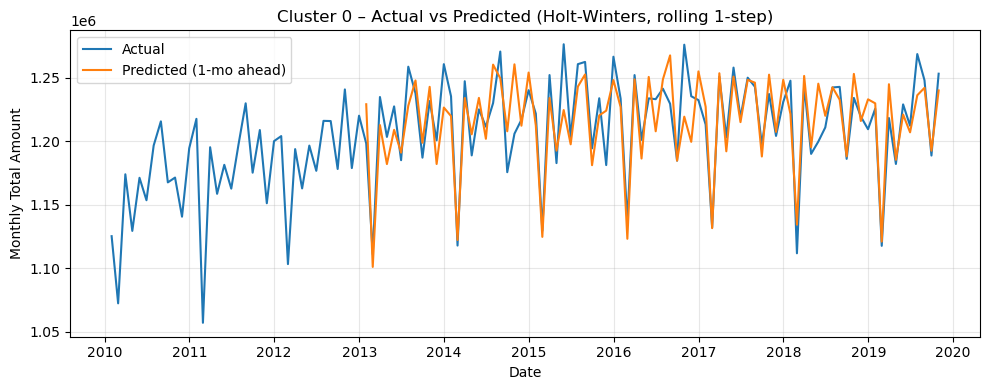

In [17]:
def plot_actual_vs_pred_hw(ts, train_len=36, title_prefix="", s=12):
    df_fc = rolling_forecast_holt_winters(
        ts,
        train_len=train_len,
        horizon=1,
        step=1,
        s=s,
        allow_multiplicative=True
    )
    df_fc = df_fc.set_index("timestamp")

    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values, label="Actual", linewidth=1.5)
    plt.plot(df_fc.index, df_fc["Pred"].values,
             label="Predicted (1-mo ahead)", linewidth=1.5)
    plt.title(f"{title_prefix}Actual vs Predicted (Holt-Winters, rolling 1-step)")
    plt.xlabel("Date"); plt.ylabel("Monthly Total Amount")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

cid = 0
ts0 = (
    cluster_monthly
    .query("Cluster == @cid")
    .assign(date=lambda d: pd.to_datetime(d["date"]))
    .set_index("date")["total_amount"]
    .asfreq("M")
    .dropna()
)

plot_actual_vs_pred_hw(ts0, train_len=36, title_prefix=f"Cluster {cid} – ")

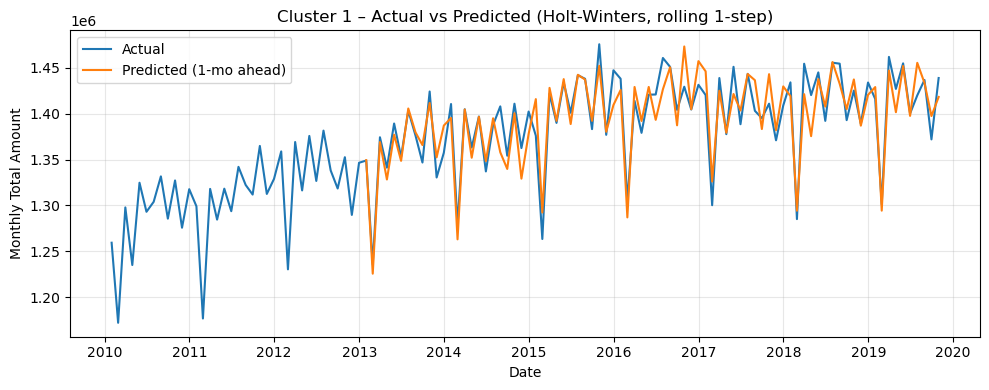

In [18]:
cid = 1
ts0 = (
    cluster_monthly
    .query("Cluster == @cid")
    .assign(date=lambda d: pd.to_datetime(d["date"]))
    .set_index("date")["total_amount"]
    .asfreq("M")
    .dropna()
)

plot_actual_vs_pred_hw(ts0, train_len=36, title_prefix=f"Cluster {cid} – ")

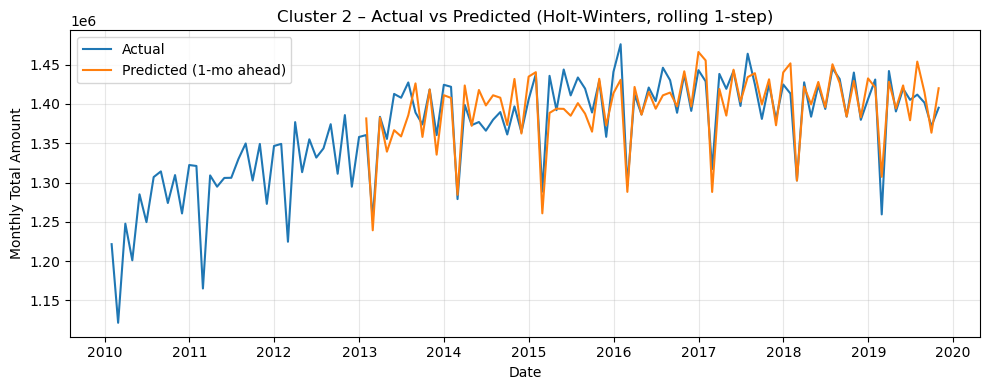

In [19]:
cid = 2
ts0 = (
    cluster_monthly
    .query("Cluster == @cid")
    .assign(date=lambda d: pd.to_datetime(d["date"]))
    .set_index("date")["total_amount"]
    .asfreq("M")
    .dropna()
)

plot_actual_vs_pred_hw(ts0, train_len=36, title_prefix=f"Cluster {cid} – ")

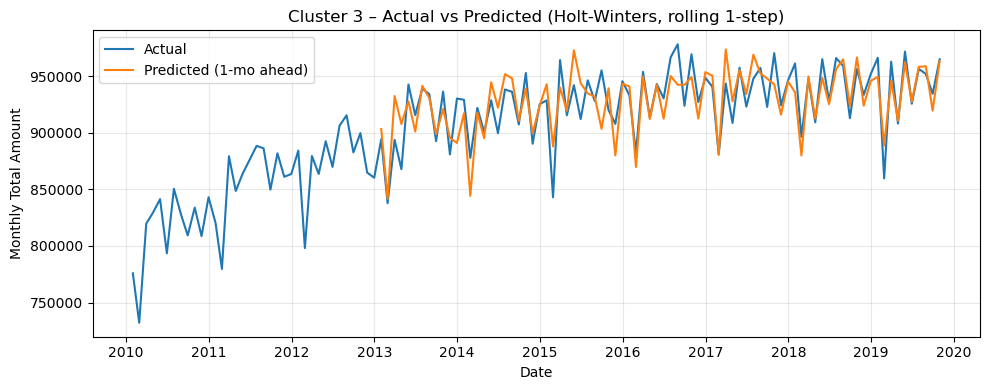

In [20]:
cid = 3
ts0 = (
    cluster_monthly
    .query("Cluster == @cid")
    .assign(date=lambda d: pd.to_datetime(d["date"]))
    .set_index("date")["total_amount"]
    .asfreq("M")
    .dropna()
)

plot_actual_vs_pred_hw(ts0, train_len=36, title_prefix=f"Cluster {cid} – ")

In [16]:
def plot_all_clusters_overlays_holt_winters(
    cluster_monthly,
    train_len=36,
    s=12,
    allow_multiplicative=True
):
    cids = sorted(cluster_monthly["Cluster"].unique())
    n = len(cids)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)

    for i, cid in enumerate(cids):
        ax = axes[i // cols][i % cols]

        ts = (
            cluster_monthly
            .query("Cluster == @cid")
            .assign(date=lambda d: pd.to_datetime(d["date"]))
            .set_index("date")["total_amount"]
            .asfreq("M")
            .dropna()
        )

        # rolling HW forecasts
        df_fc = rolling_forecast_holt_winters(
            ts,
            train_len=train_len,
            horizon=1,
            step=1,
            s=s,
            allow_multiplicative=allow_multiplicative
        )

        # make sure index is the forecast timestamps
        df_fc = (
            df_fc
            .dropna(subset=["Pred"])
            .set_index("timestamp")
            .sort_index()
        )

        ax.plot(ts.index, ts.values, label="Actual", linewidth=1.2)
        ax.plot(df_fc.index, df_fc["Pred"].values, label="Predicted", linewidth=1.2)

        ax.set_title(f"Cluster {cid}")
        ax.grid(alpha=0.3)
        if i % cols == 0:
            ax.set_ylabel("Total Amount")
        ax.set_xlabel("Date")

    # hide any empty subplots if #clusters is odd
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols][j % cols])

    # one legend for all
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

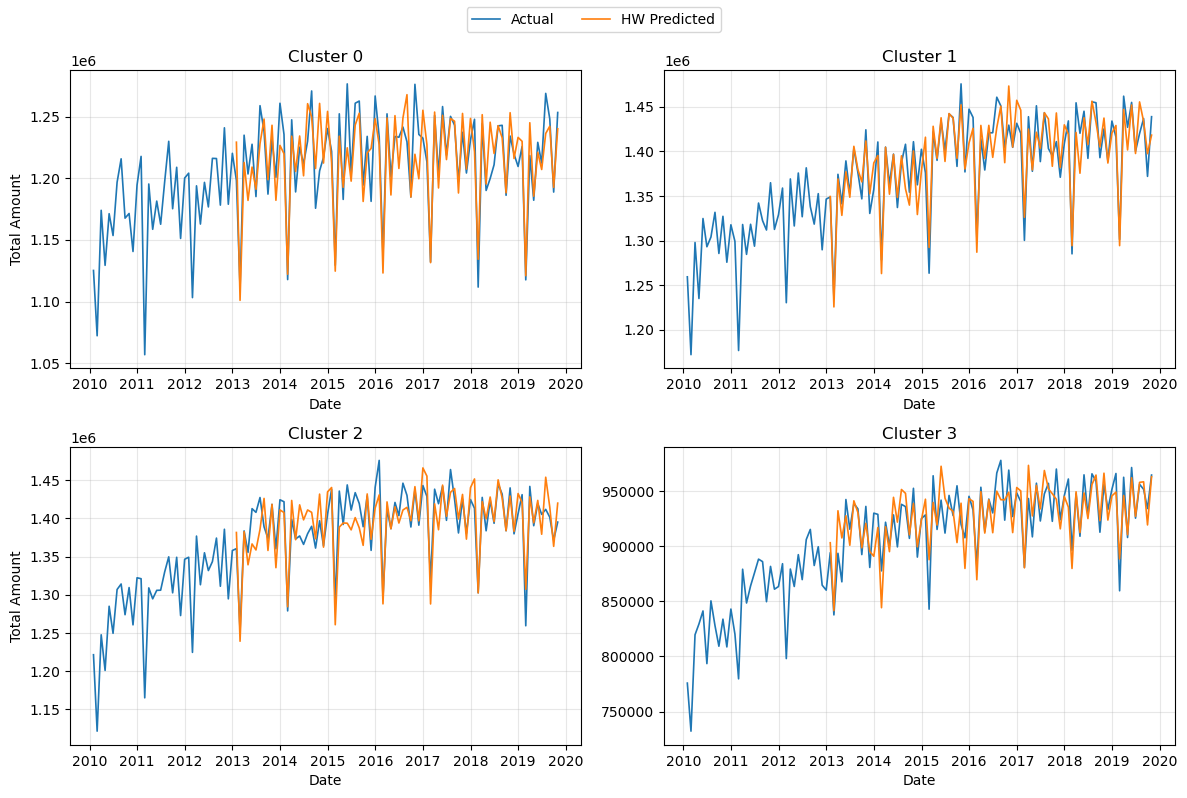

In [15]:
plot_all_clusters_overlays_holt_winters(cluster_monthly, train_len=36, s=12)